In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
import pandas as pd
import mediapipe
import warnings
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from math import cos, sin
from pathlib import Path

warnings.filterwarnings('ignore')

In [3]:
%%capture
!gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
!unzip /content/AFLW2000-3D.zip


In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
def load_image(img_id):
  image = cv2.imread('./AFLW2000/'+img_id+'.jpg')
  return image

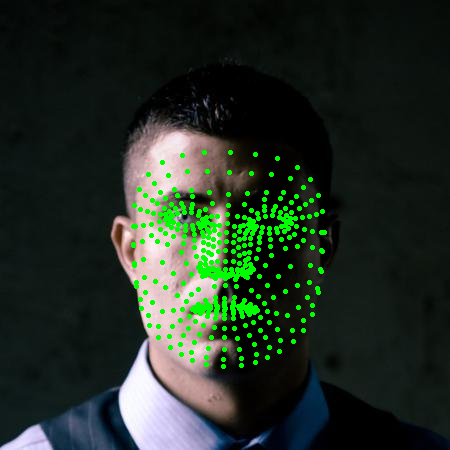

In [7]:
# choosing random image
random_id = 'image00021'

def plot_mesh(image):
  faceModule = mediapipe.solutions.face_mesh

  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)

random_image = load_image(random_id)
plot_mesh(random_image)

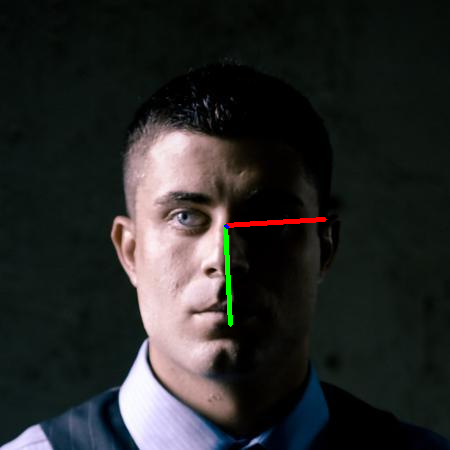

In [36]:
def plot_true_angles(image, img_id):
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  mat_file = sio.loadmat('./AFLW2000/'+img_id+'.mat')
  # extracting the labels 3 angels
  pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  cv2_imshow(draw_axis(image,pitch,yaw,roll))

random_image = load_image(random_id)
plot_true_angles(random_image, random_id)

In [29]:
def pts_from_img(image):
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      if results.multi_face_landmarks == None:
        return [], ()

      if len(results.multi_face_landmarks) > 2:
        return [], ()

      x_pts = []
      y_pts = []
      
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x_pts.append(landmark.x)
              y_pts.append(landmark.y)

      # Normalize points by centering around first point
      # & dividing by the distance between first and last point
      x_pts = np.array(x_pts)
      y_pts = np.array(y_pts)

      x_centered = x_pts - x_pts[0]
      y_centered = y_pts - y_pts[0]

      normalize_dist = np.sqrt(x_centered[-1]**2 + y_centered[-1]**2)
      x_normalized = x_centered/normalize_dist
      y_normalized = y_centered/normalize_dist

  # Return normalized pts and center pt co-ordinates
  return np.array([*x_normalized, *y_normalized]), (x_pts[0], y_pts[0])

def load_mat_data(img_id):
  mat_file = sio.loadmat('./AFLW2000/'+img_id+'.mat')

  pose = mat_file["Pose_Para"][0][:3]
  pitch = pose[0]
  yaw = pose[1]
  roll = pose[2]
  
  return np.array([pitch, yaw, roll])

random_image = load_image(random_id)

pts, _ = pts_from_img(random_image)
angles =load_mat_data(random_id)

print(pts.shape)
print(angles.shape)

(936,)
(3,)


In [10]:
## Load dataset
X = []
Y = []

err_ctr = 0

for file in glob.glob('./AFLW2000/*.jpg'):
  img_id = os.path.basename(file).split('.')[0]
  img = cv2.imread('./AFLW2000/'+img_id+'.jpg')

  x, _ = pts_from_img(img)

  if not len(x):
    err_ctr += 1
    continue

  y = load_mat_data(img_id)

  X.append(x)
  Y.append([img_id, *y])

X = np.array(X)
Y = np.array(Y)

print(f'{err_ctr} with no faces detected')

147 with no faces detected


In [11]:
print(X.shape)
print(Y.shape)

(1853, 936)
(1853, 4)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

print(X_train.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_test.shape)

(1389, 936)
(464, 936)
(1389, 4)
(464, 4)


In [13]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

def evaluate_model(model, X, Y):
  scores = cross_validate(
      model,
      X,
      Y,
      scoring=['neg_mean_squared_error', 'r2'],
      return_train_score=True,
      n_jobs=-1,
  )
  return scores

def display_model_metrics(scores, model_no):
  print('-'*16)
  for metric in scores:
    metric_prefix = metric.split('_')[0]
    if metric_prefix == 'train' or metric_prefix == 'test':
      avg = round(np.mean(scores[metric]), 4)
      std = round(np.std(scores[metric]), 4)
      print(f'model={model_no} {metric} avg={avg} std={std}')
  print('-'*16)

def predict(x):
  preds = []

  for model in models:
    preds.append(model.predict(x)[0])

  return np.array(preds)


In [25]:
models = [
          SVR(C=10, gamma='auto'),
          SVR(C=10, gamma='auto'),
          SVR(C=10, gamma='auto'),
]

for idx, model in enumerate(models):
  scores = evaluate_model(model, X, Y[:,idx+1])
  display_model_metrics(scores, idx)

for idx, model in enumerate(models):
  model.fit(X, Y[:,idx+1])

----------------
model=0 test_neg_mean_squared_error avg=-0.2439 std=0.4293
model=0 train_neg_mean_squared_error avg=-0.2422 std=0.1073
model=0 test_r2 avg=0.5555 std=0.2638
model=0 train_r2 avg=0.27 std=0.2068
----------------
----------------
model=1 test_neg_mean_squared_error avg=-0.0471 std=0.0554
model=1 train_neg_mean_squared_error avg=-0.043 std=0.0143
model=1 test_r2 avg=0.881 std=0.1123
model=1 train_r2 avg=0.874 std=0.0391
----------------
----------------
model=2 test_neg_mean_squared_error avg=-0.3087 std=0.5435
model=2 train_neg_mean_squared_error avg=-0.2939 std=0.1358
model=2 test_r2 avg=0.5947 std=0.2876
model=2 train_r2 avg=0.3797 std=0.212
----------------


[0.51052209 0.22197488 0.2606259 ]


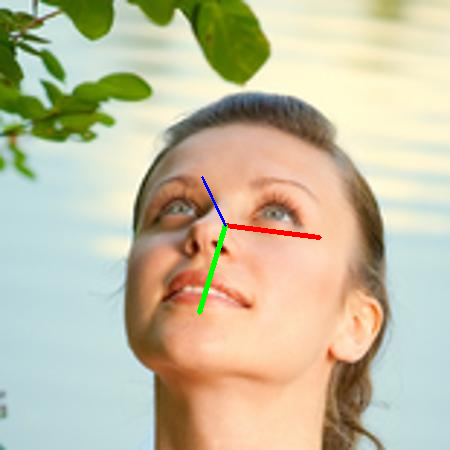

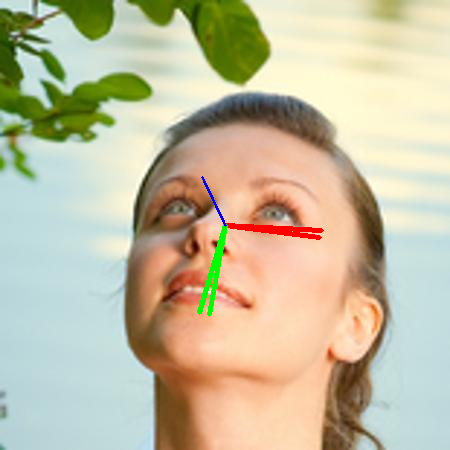

In [26]:
# Testing on img

angles_pred = predict([X[20]])

test_image = load_image(Y[20][0])
print(angles_pred)


cv2_imshow(draw_axis(test_image, *angles_pred))
plot_true_angles(test_image, Y[20][0])

In [48]:
# Applying to video

in_name = 'appropriation.mp4'
out_name = 'appropriation_angles.mp4'

cap = cv2.VideoCapture(in_name)

fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')


writer = cv2.VideoWriter(out_name, fourcc, round(fps), (int(width), int(height)))

while cap.isOpened():
  ret, frame = cap.read()

  if not ret:
    break

  pts, center_cords = pts_from_img(frame)

  if len(pts):
    angles = predict([pts])
    axis_x = center_cords[0] * width
    axis_y = center_cords[1] * height

    out_frame = draw_axis(frame, *angles, axis_x, axis_y)
  else:
    out_frame = frame
 
  writer.write(out_frame)

cap.release()
writer.release()

In [49]:
from google.colab import files
files.download(out_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>